#  Provenance integration in netcdf/xarray Data-Intensive workflows.


#### Authors: Alessandro Spinuso and Andrej Mihajlovski, 

####  Royal Netherlands Meteorological Institure (KNMI)


The following "Live" notebook demonstrates a simple workflow implemented with a data-intensive processing library (dispel4py), that has been extended with a configurable and programmable provenance tracking framework , S-PROV.

## Management Highligts, S-PROV Towards reproduciblity as a service
<ul>
<li>
The provenance information produced can be tuned and adapted to computational, precision and contextualisation requirements</li>
<li>
The freamework allows for the traceability of data-reuse across different executions, methods and users</li>
<li>The provenance can be stored as files or sent at run-time to a custom external repository</li>
<li>The repository can be searched and explored via interactive tools</li> 
<li>The provenance model is designed around an hybrid data-flow model, which takes into account data-streams and concrente data resourcese. eg. file location, webservices etc.</li>
<li>The lineage can be exported from the repository in W3C PROV format. This facilitates the production of interoperabile reports and data-curation tasks. For instance, The provenance related to specific data can be stored in W3C-PROV XML format into strucutred file formats (NetCDF) as well as istitutional and general-purpose citable data-repositories.</li>
</ul>

## Demonstration outline

### 1 - Workflow specification and execution

<ol>
  <li>Define the <i><b>Classes</b></i> of the <i><b>Workflow Components</b></i></li>
  <li>Construct the <i><b>Workflow</b></i> application</li>
  <li>Prepare the Input</li>
  <li>Visualise and run the workflow without provenance</li>
</ol>

### 2 - Provenance Types, Profiling and contextualisation

<ol>
  <li>Define the <i><b>Provenance Type</b></i> to be used within the workflow</li>
  <li><i><b>Profile</b></i> the workfow for provenance tracking</li>
  <li>Run the workflow with provenance activatied</li>
  <li>Export and embed provenance within NetCDF results</li>
  <li>Explore the resulting provenance with interactive and static visualsations</li>
</ol>

### 3 - Data-reuse traceability. 
<ol>
  <li>Change the input and demostrate consistency of provenance for data-ruse across multiple workflow executions</li>
  <li>Discuss more complex use cases and configuration options</li>
</ol>

### 4 - Informal Evaluation

SWOT form:

https://docs.google.com/presentation/d/10xlRYytR7NB9iC19T29BD-rW77ZAtnjtlukMJDP_MIs/edit?usp=sharing


## 1 - Workflow specification and execution


<ul>
<li>The dispel4py framework is utilised for the workflows</li>
<li>Xarray for inmemory management of netcdf/opendap data.</li>
<li>Matplotlib for visualisation.</li>
<li>W3C for provenance representation.</li>
</ul>

In [1]:
import xarray
#import netCDF4
import json

from dispel4py.workflow_graph import WorkflowGraph 
from dispel4py.provenance import *

from collections import OrderedDict
import time
import random

from dispel4py.base import create_iterative_chain, ConsumerPE, IterativePE, SimpleFunctionPE

import matplotlib.pyplot as plt
import traceback

from pprint import pprint

Simple Workflow, xarray in xarray out. 
The generic processing elements are defined below. the <i>GenericPE</i> bellongs to the dispel4py framework. It allows data-objects to be passed as inputs and outputs. The <i>Components</i> are linked and visualised via the workflow_graph module.

### 1.1 The three Workflow Components:

<ol>
<li>- Read, xarray is read into memory.</li>
<li>- ANALYSIS, xarray is processed/passed to output (dummy, no real changes in the example)</li>
<li>- Write, xarray is visualised.</li>
</ol>

In [2]:
class Read(GenericPE):
    
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('xarray')

    def _process(self,inputs):
        
        inputLocation = inputs['input'][0]

        ds = xarray.open_dataset( inputLocation )
    
        self.write( 'xarray' , (ds , inputs['input'][1]) , location=inputLocation )

        
#The IterativePE automatically assigns input and output ports to the component
class Write(IterativePE):
    
    def __init__(self):
        IterativePE.__init__(self)
         
            
    def _process(self,inputs):
        self.log('Write_Function')
        
        outputLocation = inputs[1]
        
        inputs[0].to_netcdf( outputLocation )
                
        self.write('location', outputLocation,location=outputLocation )
        
        
class Analysis(GenericPE):
        
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('output')
        
    def _process(self,inputs):
        self.log('Workflow_process')
        
       
        nc = inputs['input'][0]
       
        #Additional metadata can be added to the output for provenance contextualisation
        self.write('output', (nc , inputs['input'][1] ), metadata={'mycustom_term':10})







### 1.2 Construct the Workflow application

Instantiates the Components and combines them in a workflow graph which gets eventually visualised

SETTING NAME: Read
SETTING NAME: Analysis
SETTING NAME: Write


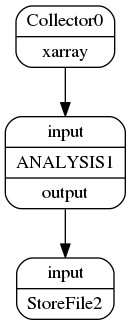

In [3]:

#Initialise the graph
def createWorkflowGraph():
    readX  = Read()
    readX.name = 'Collector'

    analyse   = Analysis()
    analyse.name    = 'ANALYSIS'
    analyse.parameters = { 'filter': 10 }

    writeX = Write()
    writeX.name = 'StoreFile'
    
    
    graph = WorkflowGraph()    
    graph.connect(readX ,'xarray'   , analyse     ,'input')
    graph.connect(analyse    ,'output'   , writeX , 'input')

    return graph



graph = createWorkflowGraph()


from dispel4py.visualisation import display
display(graph)




### 1.3 Specify the Input

A simple json representation is used to define initial input data for each named Component of the workflow.
Every component can recieve a list of inputs. These will be streamed serially or in parallel, depending from the execution mode

In [4]:
input_data = { 
                
                #'Collector': [ { 'input' : [ 'http://opendap.knmi.nl/knmi/thredds/dodsC/CLIPC/cmcc/SWE/SWE_ophidia-0-10-1_CMCC_GlobSnow-SWE-L3B_monClim_19791001-20080701_1979-2008.nc',
                #               'data/newA.nc']}]
    
                'Collector': [ { 'input': [ 'data/newA.nc', 'data/newB.nc']} ]     
                #'Collector': [ { 'input': [ 'data/newB.nc', 'data/newC.nc']}]
            }



### 1.3 Run the Workflow



In [5]:
global result

def runExampleWorkflow():
                                                     
    print input_data                   

    #Launch in simple process
    result = simple_process.process_and_return(graph, input_data)
    print "\n RESULT: "+str(result)

runExampleWorkflow()

{'Collector': [{'input': ['data/newA.nc', 'data/newB.nc']}]}
SETTING NAME: SimpleProcessingPE
ANALYSIS1: Workflow_process
StoreFile2: Write_Function
SimplePE: Processed 1 iteration.

 RESULT: {'StoreFile2': {'location': ['data/newB.nc']}}


## 2 - Provenance Types, Profiling and contextualisation

### 2.1 Define a Provenance Type

The <i>Provenance Type</i> defined below will be used to extend specific workflow components, enabling special provenance tracking properties for <i>NetCDF/xarray</i> formats.


<ul>
<li>
<b><i>makeUniqueId:</i></b> 
Generates and returns a <i>uuid</i>. This can be implemented to adhere to the hosting infrastructure best-practices.</li>
<li>
<i><b>extractExternalInputDataId:</b></i>
This method is used by the provenance type to extract the id of the incoming data. Its use is handy especially when a workflow component ingests files that have been produced by other workflows and that are represented by self-contained and structured data formats.  For instance, in NetCDF where data and metadata can be packaged together according to community standards, this method extracts and returns the id of the external resource, allowing the framework to use it in the current run to represent new dependencies. A customised implementation of this method for a provenance type that deals with domain-specific data formats, ensures the linkage and therefore the consistent continuation of provenance traces across workflow executions. </li>
<li><b><i>extractItemMetadata:</i></b>
This methods enables the configuration of the provenance for a particular domain, user or infrastructure requirement. It extracts metadata from the data written on a output channel and includes it as a detailed description of the <i>Data</i> entity within the provenance model.</li>
<li><b><i>applyFlowResetPolicy (Advanced):</i></b>
This method is invoked by each iteration when a decision has to be made on the required lineage pattern. The framework automatically passes information whether the invocation has produced any output or not (<i>on-void-iterations</i>). The method, according to predefined rules, provides indications on either discarding the current input data or to include it into the <i>StateCollection</i> automatically, capturing its contribution to the next invocation through a <i>stateful</i>operations. 
In our implementation, basic provenance types such as <i>StatefulType</i> and <i>StatelessType</i> are made available and can be used accordingly the specific needs.
</li>

</ul>


In [6]:
class netcdfProvType(ProvenancePE):
    def __init__(self):
        ProvenancePE.__init__(self)
    
    def extractExternalInputDataId(self,data, input_port):
        #Extract here the id from the data (type specific):

        self.log('ANDREJ.extractExternalInputDataId')
        #self.log(data)
        
        try:
            #ds = xarray.open_dataset(data['input'][0])
            ds = xarray.open_dataset(data[0])
            id = ds.attrs['id']
            
        except Exception, err:
            id = str(uuid.uuid1())
            self.log(str(err))
        #Return
        return id
    
    
    def makeUniqueId(self, data, output_port):      
        
        self.log('ANDREJ.makeUniqueId')
        #self.log(kwargs)
        
        #produce the id
        id=str(uuid.uuid1())
            
        ''' nc data '''
        xa = data[0]
        
        ''' unique as defined by the community standard '''
        xa.attrs['id'] = id
        
        #Return
        return id 
    

    
    ''' extracts xarray metadata '''
    def extractItemMetadata(self,data, output_port):
        
        self.log('ANDREJ.extractItemMetadata')
        #self.log(data)
        
        try:            
            nc_meta = OrderedDict()
            
            ''' cycle throug all attributes, dimensions and variables '''
            xa = data[0]
                        
            # dataset meta
            nc_meta['Dimensions'] = str( dict(xa.dims)) 
            nc_meta['Type'] = str(type(xa))
            
            # global attr
            for k , v in xa.attrs.items():
                nc_meta[str(k).replace(".","_")] = str(v)
            # vars attr   
            for n , i in xa.data_vars.items():
                for k , v in i.attrs.items():
                    nc_meta[n+"_"+str(k).replace(".","_")] = str(v)
            
            #pprint(nc_meta)
        
            metadata = [nc_meta]
            
            return metadata
                             
        except Exception, err:
            self.log("Applying default metadata extraction:"+str(traceback.format_exc()))
            self.error=self.error+"Extract Metadata error: "+str(traceback.format_exc())
            return super(netcdfProvType, self).extractItemMetadata(data);
        

### 2.2 Profile the workfow for provenance tracking

Once the Provenance types have been defined, these are used to configure, or profile, a workflow execution to comply with the desired provenance collection requirements.  Below we illustrate the framework method and the details of this approach.

<ul>

<li><b><i>profile_prov_run</i></b> With this method, the users of the workflow can profile their run for provenance by indicating which types to apply to each component. Users can also chose where to store the metadata, locally to the file system or to a remote service. These operations can be performed in bulks, with different impacts on the overall overhead and on the experienced rapidity of the access of the lineage information. Additional details on the proposed remote provenance storage and access service will be provided in Chapter V. Finally, also general information about the attribution of the run, such as <i>username, run_id, description, workflow_name, workflow_id</i> are captured and included within the provenance traces.
</li>
<li><b><i>Skip-Rules (Advanced)</i></b>
Users can tune the scale of the records produced by indicating in the above method a set of <i>skip-rules</i> for every component.This functionality allows users to specify rules to control the data-driven production of the provenance declaratively. The approach takes advantage of the contextualisation applied by the provenance types, which extract domain and experimental metadata, and evaluates their value against simple <i>skip-rule</i> of this kind:
</li>
</ul>




In [7]:
skip_rules={"ANALYSIS":{"mycustom_term":{"$gt":0,"$lt":10}}}

#### Defining provenance profile

A high JSON 'template' describing the provenance profile for a specific run.

In [8]:
prov_profile =  {
                    'username': "aspinuso", 
                    'description' : "provdemo basic",
                    'workflowName': "demo_ecmwf"      ,
                    'workflowId'  : "workflow process",
                    'save_mode'   : 'service'         ,
                    # Defines the use of the ProvenancePE with the Workflow Component
                    'componentsType' : {'ANALYSIS':(netcdfProvType,) , 'Collector':(netcdfProvType,)},
                    'skip_rules': skip_rules
                } 


#### Repository Endpoints 

The REPOS_URL is the target provenence repository. 
Used for VERCE (Seismo), CLIPC (C3S) and Climate4Impact (Climate IS-ENES)

In [9]:
#Store via service
#ProvenancePE.REPOS_URL='http://127.0.0.1:8082/workflow/insert'
ProvenancePE.REPOS_URL='http://climate4impact.eu/prov/workflow/insert'

#Export data lineage via service (REST GET Call on dataid resource)
#ProvenancePE.PROV_EXPORT_URL='http://127.0.0.1:8082/workflow/export/data/'
ProvenancePE.PROV_EXPORT_URL="http://climate4impact.eu/prov/workflow/export/data/" 


#Store to local path
ProvenancePE.PROV_PATH='./prov-files/'

#Size of the provenance bulk of documents before sending to file, service or sensor
ProvenancePE.BULK_SIZE=20


#### Execute Dynamic Profiling

The application is then profiled with the desired provenance types and attribution parmeters.

SETTING NAME: Read
SETTING NAME: Analysis
SETTING NAME: Write
{'username': 'aspinuso', 'workflowId': 'workflow process', 'description': 'provdemo basic', 'save_mode': 'service', 'skip_rules': {'ANALYSIS': {'mycustom_term': {'$gt': 0, '$lt': 10}}}, 'workflowName': 'demo_ecmwf', 'componentsType': {'Collector': (<class '__main__.netcdfProvType'>,), 'ANALYSIS': (<class '__main__.netcdfProvType'>,)}}
Change grouping implementation 
Change grouping implementation 
Injecting provenance to: ANALYSIS Original type: (<class 'dispel4py.core.GenericPE'>,)
SETTING NAME: netcdfProvType
ANALYSIS {'mycustom_term': {'$gt': 0, '$lt': 10}}
Injecting provenance to: ANALYSIS Transoformed: (<class '__main__.netcdfProvType'>, <class '__main__.Analysis'>)
Change grouping implementation 
Injecting provenance to: Collector Original type: (<class 'dispel4py.core.GenericPE'>,)
SETTING NAME: netcdfProvType
Injecting provenance to: Collector Transoformed: (<class '__main__.netcdfProvType'>, <class '__main__.Read'>)

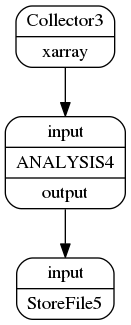

In [10]:
def createGraphWithProv():
    
    graph=createWorkflowGraph()
    #Location of the remote repository for runtime updates of the lineage traces. Shared among ProvenanceRecorder subtypes

    # Ranomdly generated unique identifier for the current run
    rid='JUP_SIMPLE_'+getUniqueId()

    
    # Finally, provenance enhanced graph is prepared:
    print prov_profile

     
    #Initialise provenance storage to service:
    profile_prov_run(graph, 
                     provImpClass=(ProvenancePE,),
                     username=prov_profile['username'],
                     runId=rid,
                     description=prov_profile['description'],
                     workflowName=prov_profile['workflowName'],
                     workflowId=prov_profile['workflowId'],
                     save_mode=prov_profile['save_mode'],
                     componentsType=prov_profile['componentsType'],
                     skip_rules=prov_profile['skip_rules']
                    )
                   

    #clustersRecorders={'record0':ProvenanceRecorderToFileBulk,'record1':ProvenanceRecorderToFileBulk,'record2':ProvenanceRecorderToFileBulk,'record6':ProvenanceRecorderToFileBulk,'record3':ProvenanceRecorderToFileBulk,'record4':ProvenanceRecorderToFileBulk,'record5':ProvenanceRecorderToFileBulk}
    #Initialise provenance storage end associate a Provenance type with specific components:
    #profile_prov_run(graph,provImpClass=ProvenancePE,componentsType={'Source':(ProvenanceStock,)},username='aspinuso',runId=rid,w3c_prov=False,description="provState",workflowName="test_rdwd",workflowId="xx",save_mode='service')

    #
    return graph


graph=createGraphWithProv()

display(graph)

### 2.3 - Run the workflow with provenance activatied

In [11]:
runExampleWorkflow()

{'Collector': [{'input': ['data/newA.nc', 'data/newB.nc']}]}
SETTING NAME: SimpleProcessingPE
Collector3: ['data/newA.nc', 'data/newB.nc']
Collector3: ANDREJ.extractExternalInputDataId
Collector3: BUILDING INITIAL DERIVATION
Collector3: ANDREJ.extractItemMetadata
Collector3: ANDREJ.makeUniqueId
ANALYSIS4: {'_d4p': (<xarray.Dataset>
Dimensions:                       (bnds: 2, time: 12, x: 721, y: 721)
Coordinates:
  * y                             (y) float64 -9.024e+06 -8.999e+06 ...
  * x                             (x) float64 -9.024e+06 -8.999e+06 ...
  * time                          (time) datetime64[ns] 1994-10-16T12:00:00 ...
  * bnds                          (bnds) int64 0 1
Data variables:
    time_bnds                     (time, bnds) datetime64[ns] 1979-10-01 ...
    lambert_azimuthal_equal_area  |S64 ''
    SWE                           (time, y, x) float64 nan nan nan nan nan ...
    lat                           (y, x) float64 nan nan nan nan nan nan nan ...
    lon      

### 2.4 - Export and embed provenance within NetCDF results

Provenance is extracted from the repository for the ouput result in PROV format.

In [12]:
# output location.
finalFile = input_data['Collector'][0]['input'][1]
print finalFile

''' read id of output to locate prov '''
ds = xarray.open_dataset( finalFile )
dataid = ds.attrs['id']     

print("Extract Trace for dataid: "+dataid)
expurl = urlparse(ProvenancePE.PROV_EXPORT_URL)
connection = httplib.HTTPConnection(expurl.netloc)
print(expurl.netloc+expurl.path+dataid+"?all=true")
connection.request(
                "GET", expurl.path+dataid+"?all=true")
response = connection.getresponse()
print("progress: " + str((response.status, response.reason)))
prov1 = response.read()
print('PROV TO EMBED:')
print str(prov1)

data/newB.nc
Extract Trace for dataid: d0006ac2-dd8c-11e6-b632-901b0e877023
climate4impact.eu/prov/workflow/export/data/d0006ac2-dd8c-11e6-b632-901b0e877023?all=true
progress: (200, '')
PROV TO EMBED:
<?xml version='1.0' encoding='ASCII'?>
<prov:document xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:prov="http://www.w3.org/ns/prov#" xmlns:dcterms="http://purl.org/dc/terms/" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:s-prov="http://s-prov">
  <prov:agent prov:id="s-prov:aspinuso">
    <dcterms:author>aspinuso</dcterms:author>
  </prov:agent>
  <prov:bundle prov:id="s-prov:JUP_SIMPLE_pc150396.knmi.nl-32205-cfe935a0-dd8c-11e6-b632-901b0e877023">
    <s-prov:_id>JUP_SIMPLE_pc150396.knmi.nl-32205-cfe935a0-dd8c-11e6-b632-901b0e877023</s-prov:_id>
    <s-prov:description>provdemo basic</s-prov:description>
    <s-prov:mapping>-f</s-prov:mapping>
    <s-prov:runId>JUP_SIMPLE_pc150396.knmi.nl-32205-cfe935a0-dd8c-11e6-b632-901b0e877023</s-prov:runId>
    <s-prov:startTime>2

And embedded into a new file 

In [13]:
#ds. create variable save to file

ds.load()
ds['provenance'] = xarray.DataArray("")
ds['provenance'].attrs['prov_xml']=str(prov1)
ds.to_netcdf(str(finalFile+"_PROV"))
ds = xarray.open_dataset(str(finalFile+"_PROV"))
print ds


<xarray.Dataset>
Dimensions:                       (bnds: 2, time: 12, x: 721, y: 721)
Coordinates:
  * y                             (y) float64 -9.024e+06 -8.999e+06 ...
  * x                             (x) float64 -9.024e+06 -8.999e+06 ...
  * time                          (time) datetime64[ns] 1994-10-16T12:00:00 ...
  * bnds                          (bnds) int64 0 1
Data variables:
    time_bnds                     (time, bnds) datetime64[ns] 1979-10-01 ...
    lambert_azimuthal_equal_area  |S64 ''
    SWE                           (time, y, x) float64 nan nan nan nan nan ...
    lat                           (y, x) float64 nan nan nan nan nan nan nan ...
    lon                           (y, x) float64 nan nan nan nan nan nan nan ...
    provenance                    |S1 ''
Attributes:
    source: SMMR L3 brightness temperatures in EASE grid, ECMWF weather station data
    auxiliary_data: GLC-2000 derived land classification mask v2.0, ETOPO-5 derived mountain mask v2.0, GLC-200

### 2.5 - Explore the resulting provenance with static and interactive visualsations

The W3C-PROV provenance trace for a target data element is visualised.

In [14]:
import prov
import io
import StringIO
from prov.model import ProvDocument, ProvBundle, ProvException, first, Literal
from prov.dot import prov_to_dot

def provToSvg(xml,output_f):
     
    xml_doc = StringIO.StringIO()
    xml_doc.write(str(xml))
    xml_doc.seek(0, 0)
    #print xml_doc
    doc=ProvDocument.deserialize(xml_doc,format="xml")
    dot = prov_to_dot(doc)
    return dot.create(format=output_f)
    

#prov_doc=open(prov).read()

#print prov1

svg_content=provToSvg(prov1,"png")

with open("PROV.png","w+") as text_file:
    text_file.write(str(svg_content))

from IPython.display import Image
Image("PROV.png")

    
# visualse NetCDF provenance in PNG

#### Storage into generic archives

The PROV Document can be store within generic archives:

https://provenance.ecs.soton.ac.uk/store/



#### Interactive tools - S-ProvFlow GUI

The model and the repository can be explored through the S-ProvFlow GUI

Access the following link and introduce your usename when asked (It has to be the same used for the workflow profiling and execution)

http://climate4impact.eu/provenance-explorer/html/view.jsp



### 3 - Data-reuse traceability.

Change the <i>1.3 Specify the Input</i> section with the commented lines alternatively. Run the notebook to see updated results, both inline and on the remote repository.

In [15]:
#import matplotlib.pyplot as plt
#import cartopy.crs as ccrs

#datamap = ds.SWE.isel(time=0)
#datamap.plot()
#plt.show()